In [2]:
%load_ext autoreload
%autoreload 2
from typing import List

import os
from copy import copy
from itertools import combinations, permutations
import pickle
from random import choice, random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

In [3]:
from cube import Cube3D

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

We try to address the 3rd question from the previous notebook.

## Define the target for the greedy algorithm
What 'sort loss' function we use for a rubik's cube?

$$
\text{SL} = \sum_{i=1}^{n-1} \sum_{j=i+1}^{n} [x_i > x_j]
$$

Maybe stick to this one? With only difference in excluding zeroes (for the rubik's cube case)

In [5]:
cube = Cube3D(3)

In [6]:
cube.cube

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[10, 11, 12],
        [13, 14, 15],
        [16, 17, 18]],

       [[19, 20, 21],
        [22, 23, 24],
        [25, 26, 27]]])

In [7]:
cube.sort_loss()

0

How we define this group's actions?

Each side has a pattern of [1 2 3 4 5 6 7 8] -> [7 8 1 2 3 4 5 6]

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|


4 possible action types:

I.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|<span style="color:blue">c</span>|<span style="color:blue">d</span>|<span style="color:blue">e</span>|<span style="color:blue">f</span>|<span style="color:blue">g</span>|<span style="color:blue">h</span>|<span style="color:blue">a</span>|<span style="color:blue">b</span>|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|

II.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c|d|e|f|g|h|<span style="color:blue">k</span>|<span style="color:blue">l</span>|<span style="color:blue">m</span>|<span style="color:blue">n</span>|<span style="color:blue">o</span>|<span style="color:blue">p</span>|<span style="color:blue">i</span>|<span style="color:blue">j</span>|q|r|s|t|u|v|w|x|

III.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b||d|e|f|g||i|j||l|m|n|o||||||u|v|w|x|

IV.

|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|
|-|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|--|--|--|--|--|--|--|
|a|b|c||e|f||h|i|j|k||m|n||p|q|r|s|t|||||

The train data can be easily generated for the greedy algorithm and fixed sequence length as the most optimal action in terms of previously defined 'sort loss':

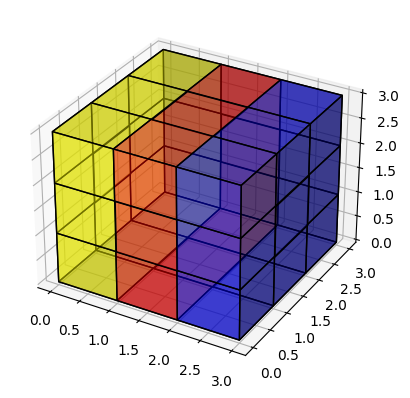

In [8]:
cube.plot()

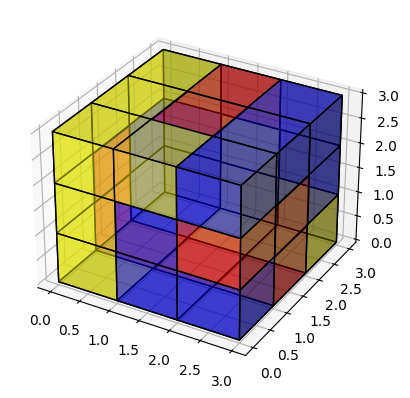

In [9]:
cube.mix(steps=100)
cube.plot()

In [10]:
cube.sort_loss()

130

## Prepare train data

Input - reshaped to 1-D array cube. <br>
Output - best next action in terms of sort loss optimization (including "ideal"). <br><br>

Output can be assessed as the best next step, best next step leading to better second next step and so on. <br>
So we will try:
- 1 step
- 2 step
- 3 step
optimizations.

In [13]:
# generate simple data
from copy import deepcopy
import pickle
import random


def generate_data(dataset_size, num_steps):
    DATA = []
    cube = Cube3D(3)
    output_array_size = len(cube.get_actions_possible().keys())
    for i in range(dataset_size):
        if i%1000 == 0:
            print(f'{i} lines generated.')
        cube.mix(random.randint(0, 10))
        init_loss = cube.sort_loss()
        best_action = 0
        for actions in list(set(permutations(list(cube.get_actions_possible().keys())*num_steps, num_steps))):
            cp_cube = deepcopy(cube)
            for action in actions:
                cp_cube.apply_action(action)
            new_loss = cp_cube.sort_loss()
            if new_loss < init_loss:
                init_loss = new_loss
                best_action = actions[0]
        output = [0]*output_array_size
        output[best_action] = 1
        DATA.append((deepcopy(cube), output))
    return DATA


def split_data(data, split_rate=0.9):
    train_data = []
    test_data = []
    for row in data:
        input_data = row[0].flattened
        if random.random() < split_rate:
            train_data.append([input_data, row[1]])
        else:
            test_data.append([input_data, row[1]])
    return train_data, test_data


def dump_data(train_data, test_data, dataset_size, num_steps, split_rate, prefix=''):
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_train.pkl', 'wb') as f:
        pickle.dump(train_data, f)
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_test.pkl', 'wb') as f:
        pickle.dump(test_data, f)


def load_data(dataset_size, num_steps, split_rate, prefix=''):
    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_train.pkl', 'rb') as f:
        train_data = pickle.load(f)

    with open(f'../data/{prefix}_{num_steps}_{dataset_size}_{split_rate}_test.pkl', 'rb') as f:
        test_data = pickle.load(f)

    return train_data, test_data


## 1 step optimization

In [37]:
# v1 is a simple attempt of using defined convex sort loss and 1/2/3 steps optimization.

DATASET_SIZE = 100000
STEPS = 1
SPLIT_RATE = 0.9
PREFIX = 'v1'

try:
    train_data, test_data = load_data(DATASET_SIZE, STEPS, SPLIT_RATE, PREFIX)
except:
    data = generate_data(DATASET_SIZE, STEPS)
    train_data, test_data = split_data(data, SPLIT_RATE)
    dump_data(train_data, test_data, DATASET_SIZE, STEPS, SPLIT_RATE, PREFIX)

In [38]:
# # sanity check
# i = 10
# print(data[i][0].sort_loss())
# print(data[i])
# print(data[i][1].index(1))
# for action in cube.get_actions_possible().keys():
#     _cube = deepcopy(data[i][0])
#     _cube.apply_action(action)
#     print(action, _cube.sort_loss())

### Define a simple sorter neural network

In [39]:
class SorterNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(SorterNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


In [40]:
train_data[0]

[array([ 3, 12, 21, 22, 13,  4,  7,  2,  9, 20, 23, 26, 17, 14, 11, 16,  5,
        18,  1, 10, 19, 24, 15,  6, 25,  8, 27]),
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [41]:
input_train_data = torch.tensor([x[0] for x in train_data], dtype=torch.float32)
output_train_data = torch.tensor([x[1] for x in train_data], dtype=torch.float32)

input_test_data = torch.tensor([x[0] for x in test_data], dtype=torch.float32)
output_test_data = torch.tensor([x[1] for x in test_data], dtype=torch.float32)    

In [42]:
PATH = f'../models/{PREFIX}_{STEPS}_{DATASET_SIZE}_{SPLIT_RATE}_model.pkl'

input_size = input_train_data.shape[1]
output_size = output_train_data.shape[1]
hidden_size = 64

model = None
if not os.path.exists(PATH):
    model = SorterNN(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 5000
    for epoch in range(num_epochs):
        outputs = model(input_train_data)
        loss = criterion(outputs, output_train_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    torch.save(model.state_dict(), PATH)
else:
    model = SorterNN(input_size, hidden_size, output_size)
    model.load_state_dict(torch.load(PATH))
    model.eval()

Epoch [1000/5000], Loss: 2.5377
Epoch [2000/5000], Loss: 2.4860
Epoch [3000/5000], Loss: 2.4826


In [30]:
wrong = 0
errors = 0
for test_row in test_data:
    test_input = torch.tensor([test_row[0]], dtype=torch.float32)
    predicted_output = model(test_input).round()
    try:
        if test_row[1].index(1) != predicted_output.detach().numpy()[0].tolist().index(1):
            wrong += 1
    except:
        errors += 1

In [31]:
wrong, len(test_data), errors

(627, 979, 2)

Let's test the sorting

In [32]:
cube = Cube3D(3)
cube.mix(5)
cube.sort_loss()

168

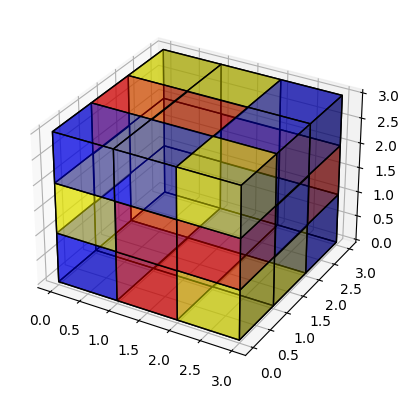

In [621]:
cube.plot()

In [36]:
import random

v = cube.sort_loss()
i = 0
cutoff = 0
max_iter = 100000
while v > cutoff:
    test_input = torch.tensor([cube.flattened], dtype=torch.float32)
    predicted_output = model(test_input)
    try:
        if random.random() < 0.7:
            action = predicted_output.detach().numpy().astype(int).tolist()[0].index(1)
        else:
            action = random.randint(0, 18)
    except:
        print('error')
        action = random.randint(0, 18)
    cube.apply_action(action)
    v = cube.sort_loss()
    i += 1
    print(f'Action: {action}', i, v)
    if i > max_iter:
        print(f'Failed ')
        break

Action: 8 1 96
Action: 3 2 86
error
Action: 18 3 90
error
Action: 8 4 126
Action: 8 5 146
Action: 8 6 108
Action: 16 7 114
Action: 8 8 102
Action: 8 9 134
error
Action: 10 10 168
Action: 13 11 180
Action: 3 12 136
error
Action: 13 13 130
Action: 3 14 116
Action: 12 15 106
Action: 18 16 108
Action: 1 17 68
Action: 4 18 84
Action: 3 19 68
Action: 4 20 84
Action: 3 21 68
Action: 4 22 84
Action: 3 23 68
Action: 4 24 84
Action: 3 25 68
Action: 4 26 84
Action: 3 27 68
Action: 4 28 84
Action: 3 29 68
Action: 4 30 84
Action: 3 31 68
Action: 4 32 84
Action: 3 33 68
Action: 1 34 108
Action: 18 35 94
Action: 7 36 112
Action: 16 37 110
error
Action: 16 38 128
Action: 1 39 116
Action: 11 40 122
Action: 9 41 178
Action: 10 42 122
Action: 9 43 178
Action: 2 44 156
Action: 10 45 110
Action: 1 46 138
error
Action: 12 47 136
error
Action: 17 48 148
error
Action: 9 49 192
Action: 10 50 148
Action: 18 51 136
error
Action: 16 52 140
Action: 18 53 130
error
Action: 16 54 124
error
Action: 18 55 136
Action: 

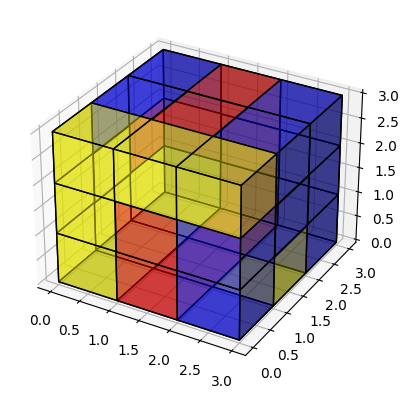

In [624]:
cube.plot()